In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

# Outliers & Univariate EDA

In [2]:
import numpy as np
import pandas as pd

from scipy import stats
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt

# Not needed, I went overkill on a viz
import skimage.io
import wordcloud

%matplotlib inline

postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "youtube"

conn_str = f"postgresql://{postgres_user}:{postgres_pw}@{postgres_host}:{postgres_port}/{postgres_db}"

query = """
SELECT *
FROM youtube
"""

youtube_df = pd.read_sql_query(query, con=conn_str)
youtube_df.head()

/usr/local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,Rank,Grade,Channel name,Video Uploads,Subscribers,Video views
0,1st,A++,Zee TV,82757,18752951,20869786591
1,2nd,A++,T-Series,12661,61196302,47548839843
2,3rd,A++,Cocomelon - Nursery Rhymes,373,19238251,9793305082
3,4th,A++,SET India,27323,31180559,22675948293
4,5th,A++,WWE,36756,32852346,26273668433


<IPython.core.display.Javascript object>

In [3]:
youtube_df.isna().mean()

Rank             0.0
Grade            0.0
Channel name     0.0
Video Uploads    0.0
Subscribers      0.0
Video views      0.0
dtype: float64

<IPython.core.display.Javascript object>

## Identifying Outliers

### Eyeballing

We can just try and look through the data to see outliers... This doesn't work too well...

In this data we have a huge range of values, from just seeing the `.head()` and the `.tail()` we can't tell if the high numbers are outliers, the low numbers are outliers, or if it smoothly covers the full range.

In [4]:
youtube_df.shape

(5000, 6)

<IPython.core.display.Javascript object>

In [5]:
youtube_df["Video views"].sort_values().head()

2405       75
326       350
1294     8496
1350     9495
2973    74014
Name: Video views, dtype: int64

<IPython.core.display.Javascript object>

In [6]:
youtube_df["Video views"].sort_values().tail()

3    22675948293
6    23898730764
8    24518098041
4    26273668433
1    47548839843
Name: Video views, dtype: int64

<IPython.core.display.Javascript object>

### Visualization

A better way would be to use one of the distribution visualizations we know.

In [7]:
# boxplot's think outliers are points that are further than:
# "1.5 * IQR" away from the mean (inter-quartile range)

<IPython.core.display.Javascript object>

In [8]:
desc = youtube_df["Video views"].describe()
iqr = desc["75%"] - desc["25%"]
1.5 * iqr

1407202321.5

<IPython.core.display.Javascript object>

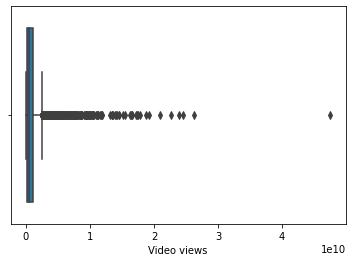

<IPython.core.display.Javascript object>

In [9]:
sns.boxplot(youtube_df["Video views"])
plt.show()

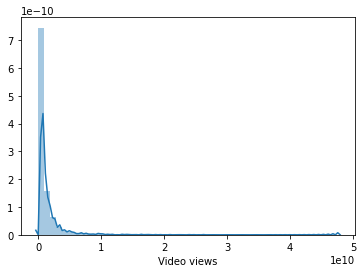

<IPython.core.display.Javascript object>

In [10]:
sns.distplot(youtube_df["Video views"])
plt.show()

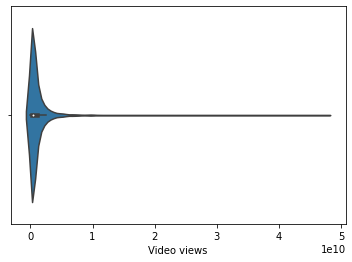

<IPython.core.display.Javascript object>

In [11]:
sns.violinplot(youtube_df["Video views"])
plt.show()

### Cutoff values

#### Z scores

To be a little more formal we could look into calculating $z$ scores for our observations.

The `scipy.stats` module has a function for calculating this, but there's also a custom implementation below to see what's actually being done.  In english, the formula is, for each observation, subtract the mean and divide by the standard deviation.  Intuitively, a $z$ score tells you how many standard deviations from the mean each observation is.

<p align='center'>
  <img src='https://i0.wp.com/www.drdawnwright.com/wp-content/uploads/2019/09/ER1.png' width=50%>
</p>

##### By 'hand' example

This might just be referred to as 'scaling'.

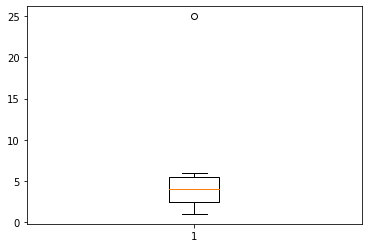

<IPython.core.display.Javascript object>

In [12]:
plt.boxplot([1, 2, 3, 4, 5, 6, 25])
plt.show()

In [13]:
sample = np.array([1, 2, 3, 4, 5, 6, 25])

mean = sample.mean()
std = sample.std()
z_scores = (sample - mean) / std

z_scores

array([-0.72471179, -0.59463532, -0.46455884, -0.33448237, -0.20440589,
       -0.07432941,  2.39712362])

<IPython.core.display.Javascript object>

##### Using functions

So we can calculate these scores; so what?  With the scores, you can decide on a threshold that indicates just how far you want your data to go.  There's no perfect rule-of-thumb value.  If using this method, try some values and see how it affects your data (i.e. cuts out too much of the data as outliers? not enough?)

In [14]:
# Function to calculate z score
def calc_zscore(sample):
    mean = sample.mean()
    std = sample.std()
    z_scores = (sample - mean) / std

    return z_scores

<IPython.core.display.Javascript object>

In [15]:
# Calculate z score with scipy.stats
scipy_z = stats.zscore(youtube_df["Video views"])

# Calculate z score with custom function
homebrew_z = calc_zscore(youtube_df["Video views"])

<IPython.core.display.Javascript object>

In [16]:
# View the first 5 elements of each z score output to see differences
scipy_z[:5]

array([ 9.8811672 , 23.19643621,  4.3529976 , 10.78260582, 12.5781947 ])

<IPython.core.display.Javascript object>

In [17]:
homebrew_z[:5]

0     9.880179
1    23.194116
2     4.352562
3    10.781528
4    12.576937
Name: Video views, dtype: float64

<IPython.core.display.Javascript object>

In [18]:
# Officially test that we're in the same ball park for scores
np.allclose(scipy_z, homebrew_z, atol=0.003)

True

<IPython.core.display.Javascript object>

#### IQR

The interquartile range can also be used with some thresholding to decide whats an outlier.  This is how boxplots typically decide which points are outliers.  See reading for more...

### Handling outliers

Before you do anything about outliers you want to be intimately familiar with the data.  Why are there outliers? are they valid? do the outliers affect the analysis? how?

You need to weigh the costs/benefits of dropping/modifying outliers in light of your goals for the project.  Are the outliers 'pattern breaking' or are they extreme in a predictable way?

Quote from John Tukey (super smart/influential stats guy):

> Sets of observations which have been de-tailed by over-vigorous use of a rule for rejecting outliers are inappropriate, since they are not samples.

Quote from Francis Bacon (maybe quote.. maybe paraphrase.. can't find good source)

> We learn once when we establish the general rule, and learn again when we investigate the exceptions.

In [19]:
# fmt: off
df = {
    'n_drinks': [6, 2, 12, 6, 6, 5, 1, 5, 4, 
                 4, 4,  3, 5, 1, 6, 4, 6, 2,
                 2, 2,  2, 6, 5, 2, 4, 6, 1,
                 6, 3,  2, 1],
    'blood_alcohol_content': [0.355, 0.132, 0.714, 0.354, 0.368, 0.292, 0.06 , 0.288, 0.25 ,
                              0.233, 0.243, 0.167, 0.298, 0.065, 0.363, 0.251, 0.356, 0.111,
                              0.131, 0.119, 0.111, 0.364, 0.305, 0.115, 0.247, 0.367, 0.702,
                              0.375, 0.192, 0.117, 0.062],
}
# fmt: on

<IPython.core.display.Javascript object>

Identify any outliers in the `'blood_alcohol_content'` column.

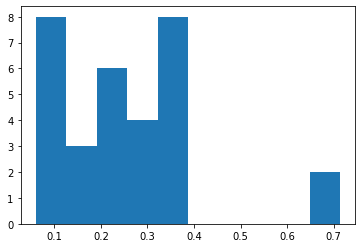

<IPython.core.display.Javascript object>

In [20]:
plt.hist(df["blood_alcohol_content"])
plt.show()

[-1.28517577 -1.2724207  -1.2532881  -0.95992158 -0.95992158 -0.93441145
 -0.92165639 -0.90890132 -0.83237092 -0.82599339 -0.60277973 -0.44334141
 -0.18186255 -0.11808722 -0.09257709 -0.07344449 -0.06706696  0.16890176
  0.19441189  0.23267709  0.27731982  0.58981894  0.59619647  0.60257401
  0.64721674  0.65359427  0.67272687  0.6791044   0.72374713  2.80920043
  2.88573083]


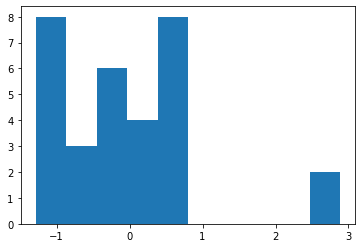

<IPython.core.display.Javascript object>

In [21]:
z = stats.zscore(df["blood_alcohol_content"])
z.sort()
print(z)

# Note this doesnt change the shape
plt.hist(z)
plt.show()

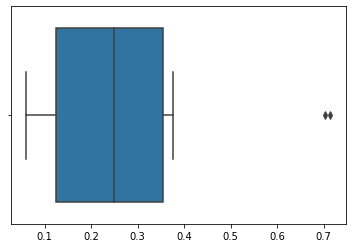

<IPython.core.display.Javascript object>

In [22]:
sns.boxplot(df["blood_alcohol_content"])
plt.show()

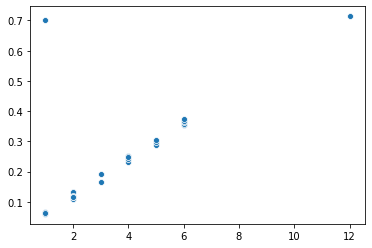

<IPython.core.display.Javascript object>

In [23]:
sns.scatterplot("n_drinks", "blood_alcohol_content", data=df)
plt.show()

back to YouTube...

#### Strategies covered in the reading

* Drop outliers (know the impact of the info you're removing before doing so; adam's preferred for 'pattern breaking' outliers)
* Winsorization (know the impact of the info you're adjusting before doing so; adam's least favorite & least used)
* Transformation (keeps all information/observations; adam's preferred for 'pattern following' outliers)

#### Example

Let's start by exploring 2 common transformations for data.  We can apply them and then plot them to see how they affect the distribution.

In [24]:
log_views = np.log(youtube_df["Video views"])
sqrt_views = np.sqrt(youtube_df["Video views"])

<IPython.core.display.Javascript object>

Create plots for the transformed variables.  Which is the most normal?

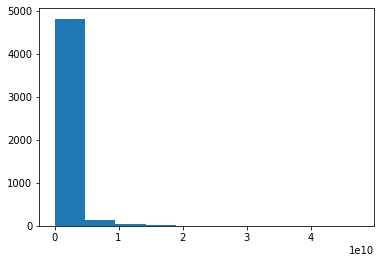

<IPython.core.display.Javascript object>

In [25]:
plt.hist(youtube_df["Video views"])
plt.show()

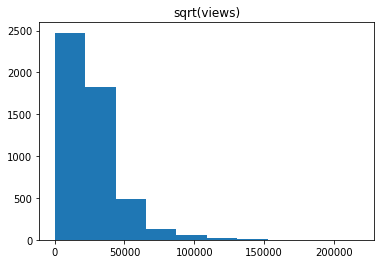

<IPython.core.display.Javascript object>

In [26]:
plt.hist(sqrt_views)
plt.title("sqrt(views)")
plt.show()

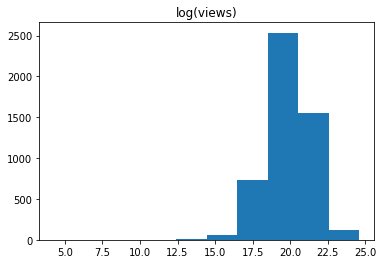

<IPython.core.display.Javascript object>

In [27]:
plt.hist(log_views)
plt.title("log(views)")
plt.show()

It's important to remember you're not limited to a single strategy.  It looks like we're almost normal with the log transform.  We have a little left skew, we could see what dropping extreme outliers with a z-score method might do.  We'll use a cutoff value of 3.

Our results show that we only lose 19 of our 5000 observations; this removal rate of 0.3% is not bad at all, especially since our data is now normal for most intents and purposes.

In [28]:
z_scores = stats.zscore(log_views)
outlier_filter = abs(z_scores) <= 3
outlier_filter

array([ True, False,  True, ...,  True,  True,  True])

<IPython.core.display.Javascript object>

There were 19 observations removed by z-score.


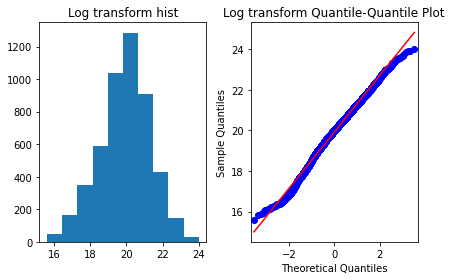

<IPython.core.display.Javascript object>

In [29]:
filtered_log_views = log_views.values[outlier_filter]

# Show count of lost observations
print(
    f"There were {len(log_views) - len(filtered_log_views)} observations removed by z-score."
)

# Re-check histogram and normal QQ plot
# Going to use side by side plots via subplots
# plt.subplots(n_rows, n_cols)
fig, axes = plt.subplots(1, 2)

axes[0].hist(filtered_log_views)
sm.qqplot(filtered_log_views, line="s", ax=axes[1])

axes[0].set_title("Log transform hist")
axes[1].set_title("Log transform Quantile-Quantile Plot")

plt.tight_layout()
plt.show()

Okay, we transformed a variable to be more normal, so what?

* Create a scatter plot of 'Video views' & 'Video Uploads' before transformation.

* Log transform both and then remake the same scatter plot

In [30]:
youtube_df["Video Uploads"].isna().sum()

0

<IPython.core.display.Javascript object>

In [31]:
youtube_df["Video Uploads"] = pd.to_numeric(
    youtube_df["Video Uploads"], errors="coerce"
)
youtube_df["Video Uploads"].isna().sum()

6

<IPython.core.display.Javascript object>

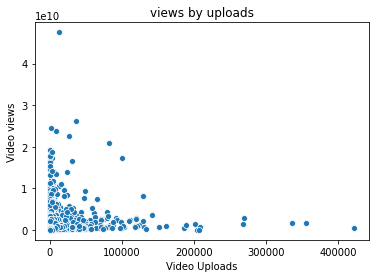

<IPython.core.display.Javascript object>

In [32]:
sns.scatterplot(youtube_df["Video Uploads"], youtube_df["Video views"])
plt.title("views by uploads")
plt.show()

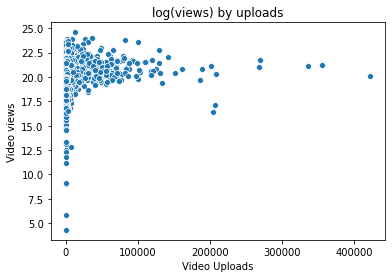

<IPython.core.display.Javascript object>

In [33]:
sns.scatterplot(youtube_df["Video Uploads"], np.log(youtube_df["Video views"]))
plt.title("log(views) by uploads")
plt.show()

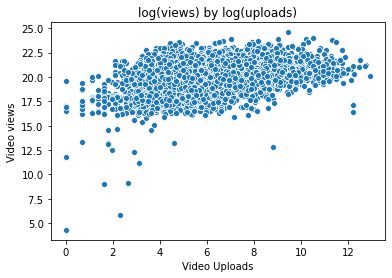

<IPython.core.display.Javascript object>

In [34]:
sns.scatterplot(np.log(youtube_df["Video Uploads"]), np.log(youtube_df["Video views"]))
plt.title("log(views) by log(uploads)")
plt.show()

A negative of transforms is that their less intuitive to think about and interpret.  If we built a linear model to predict views given the number of uploads, we might discover that for every 10 uploads we expect 5 views.  However, if we've done log transforms to our data we lose a little bit of this interpretability; interpreting these types of models is [still doable](https://stats.stackexchange.com/a/18639/102646), but definitely less intuitive.  You need to weigh the pros/cons of the accuracy/interpretability trade-off when making modeling decisions.

## Further EDA

What grades occurred the most? Which the least?  (include a visualization)

In [35]:
# The grades all have trailing whitespace
# and we have a weird \xa0
# more on that weird thing here:
# https://stackoverflow.com/a/11566398/5731525

# moral of the story, using strip to remove
# whitespace solves our problems
youtube_df["Grade"].unique()

array(['A++ ', 'A+ ', 'A ', '\xa0 ', 'A- ', 'B+ '], dtype=object)

<IPython.core.display.Javascript object>

In [36]:
youtube_df["Grade"] = youtube_df["Grade"].str.strip()
youtube_df["Grade"].unique()

array(['A++', 'A+', 'A', '', 'A-', 'B+'], dtype=object)

<IPython.core.display.Javascript object>

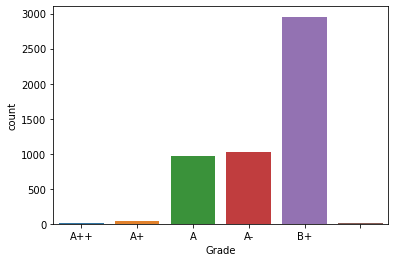

<IPython.core.display.Javascript object>

In [37]:
sns.countplot("Grade", order=["A++", "A+", "A", "A-", "B+", ""], data=youtube_df)
plt.show()

----

Below is just to show that the `wordcloud` package can produce prettier wordclouds than what was shown in the reading.  Remember that prettiness doesn't really factor into EDA though; save prettiness for presentations/reports/etc.

mask shape: (512, 512, 4)


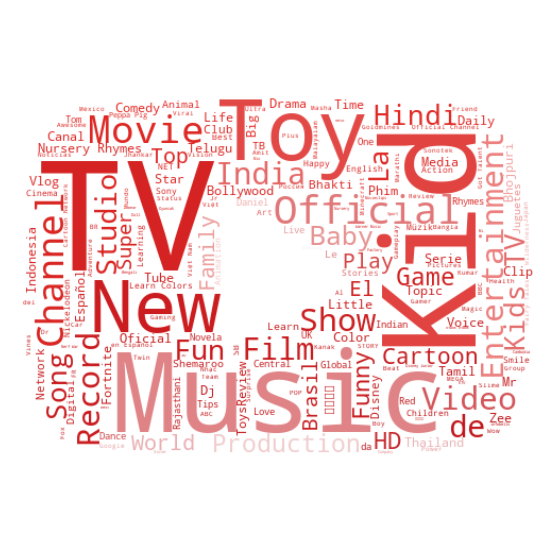

<IPython.core.display.Javascript object>

In [38]:
# Create text that will be analyzed
channel_name_text = " ".join(youtube_df["Channel name"])

# Download youtube logo to format wordcloud shape/color
# The mask will be a 3d numpy array: (height, width, [RGBA]); where RGBA = Red Green Blue Alpha
# The first 3 channels are RGB.  Black in RGB is (0, 0, 0); white is (255, 255, 255)
# The fourth channel is Alpha (aka Transparency).  0 is opaque; 255 is transparent.
mask = skimage.io.imread(
    "https://seeklogo.net/wp-content/uploads/2016/06/YouTube-icon.png"
)
print(f"mask shape: {mask.shape}")

# After inspection we notice that alot of pixels have value (0, 0, 0, 0); aka opaque black
# We'd like these pixels to be transparent.
# An easy way to do this is to set all these pixels to (255, 255, 255, 255); aka transparent white
mask[np.where(mask == [0, 0, 0, 0])] = 255

# Pass mask to WordCloud to shape our outputted plot
channel_wordcloud = wordcloud.WordCloud(background_color="white", mask=mask).generate(
    channel_name_text
)

# Use mask and ImageColorGenerator to color our outputted plot
color_gen = wordcloud.ImageColorGenerator(mask)
channel_wordcloud = channel_wordcloud.recolor(color_func=color_gen)

plt.figure(figsize=(20, 10))
plt.imshow(channel_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()